In [43]:
import seaborn as sb, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from matplotlib_venn import venn2

In [11]:
df_train = pd.read_csv('../UNSW-NB15/data/UNSW_NB15_training-set.csv')
df_test = pd.read_csv('../UNSW-NB15/data/UNSW_NB15_testing-set.csv')

In [12]:
del df_train["id"]
del df_test["id"]
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

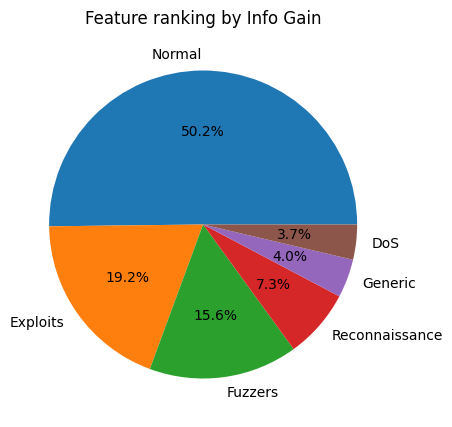

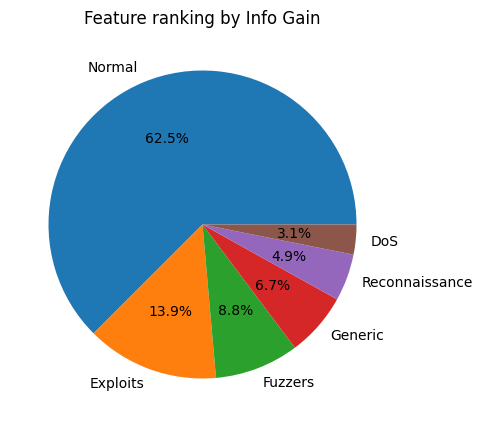

In [13]:

df_train["attack_cat"] = df_train["attack_cat"].apply(lambda x: x if x not in ('Worms', 'Analysis', 'Backdoor', 'Shellcode') else None) 
df_test["attack_cat"] = df_test["attack_cat"].apply(lambda x: x if x not in ('Worms', 'Analysis', 'Backdoor', 'Shellcode') else None) 

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

plt.figure(figsize=(12,5))
plt.title("Feature ranking by Info Gain")
plt.pie(df_train["attack_cat"].value_counts(normalize=True).values, labels=df_train["attack_cat"].value_counts(normalize=True).index, autopct='%.1f%%')
plt.show()

plt.figure(figsize=(12,5))
plt.title("Feature ranking by Info Gain")
plt.pie(df_test["attack_cat"].value_counts(normalize=True).values, labels=df_test["attack_cat"].value_counts(normalize=True).index, autopct='%.1f%%')
plt.show()

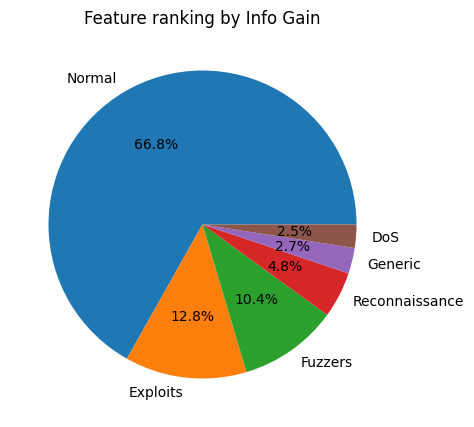

In [14]:
df_train_add = df_train[df_train["label"] == 0]

df_train = pd.concat([df_train,df_train_add])

plt.figure(figsize=(12,5))
plt.title("Feature ranking by Info Gain")
plt.pie(df_train["attack_cat"].value_counts(normalize=True).values, labels=df_train["attack_cat"].value_counts(normalize=True).index, autopct='%.1f%%')
plt.show()

In [15]:
numeric_cols = df_train.columns.difference(["service", "proto", "state", "attack_cat", "label"])
scaler = MinMaxScaler()
df_train[numeric_cols] = scaler.fit_transform(df_train[numeric_cols])
df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])

In [16]:
enc = OrdinalEncoder().set_output(transform="pandas")
df_train["attack_cat"] = enc.fit_transform(df_train[["attack_cat"]])
df_test["attack_cat"] = enc.transform(df_test[["attack_cat"]])

df_train["attack_cat"] = df_train["attack_cat"].astype(int)
df_test["attack_cat"] = df_test["attack_cat"].astype(int)

In [17]:
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False).set_output(transform="pandas")
df_train_trans_cats = enc.fit_transform(df_train[["service", "proto", "state"]])
df_test_trans_cats = enc.transform(df_test[["service",  "proto", "state"]])

df_train = pd.concat([df_train, df_train_trans_cats], axis=1).drop(["service", "proto", "state"], axis=1)
df_test = pd.concat([df_test, df_test_trans_cats], axis=1).drop(["service", "proto", "state"], axis=1)

df_train = df_train[[c for c in df_train if c not in ['attack_cat', 'label']] 
   + ['attack_cat', 'label']]
df_test = df_test[[c for c in df_test if c not in ['attack_cat', 'label']] 
   + ['attack_cat', 'label']]

In [ ]:
X_train, y_train = df_train.iloc[:, 0:-2], df_train.iloc[:, -2]
X_test, y_test = df_test.iloc[:, 0:-2], df_test.iloc[:, -2]

model = MLPClassifier(random_state=13, max_iter=500)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)

In [44]:
print("\nClassification report:")
print(classification_report(y_test, y_preds))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_preds))
print("\nAccuracy:")
print(accuracy_score(y_test, y_preds))
print("\nPrecision:")
print(precision_score(y_test, y_preds, average="weighted"))
print("\nRecall:")
print(recall_score(y_test, y_preds, average="weighted"))
print("\nF1-score:")
print(f1_score(y_test, y_preds, average="weighted"))


Classification report:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      7609
           1       0.33      0.29      0.31      4838
           2       0.93      0.89      0.91     34206
           3       0.72      0.80      0.76      8078

    accuracy                           0.81     54731
   macro avg       0.67      0.70      0.68     54731
weighted avg       0.81      0.81      0.81     54731


Confusion matrix:
[[ 6235   135   237  1002]
 [  602  1391  1934   911]
 [  764  2568 30283   591]
 [ 1379    99   167  6433]]

Accuracy:
0.8101807019787689

Precision:
0.8122844255487437

Recall:
0.8101807019787689

F1-score:
0.8097702502292734


In [19]:
df_train_unduplicated = df_train.drop_duplicates()
X_train_num, y_train_und = df_train_unduplicated.iloc[:, 0:39], df_train_unduplicated.iloc[:, -2]

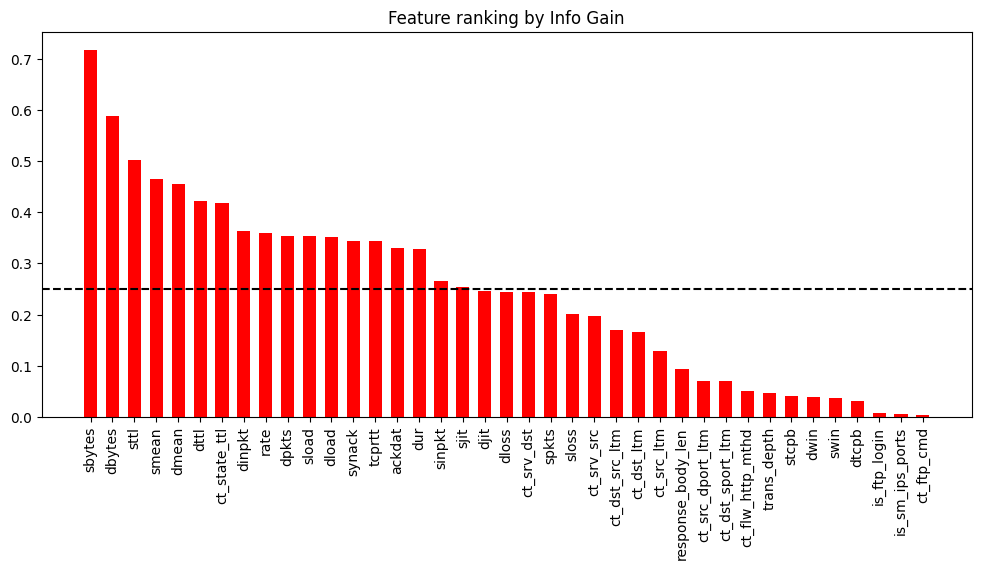

In [20]:
mutual_info = mutual_info_classif(X_train_num, y_train_und)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_num.columns
mutual_info = mutual_info.sort_values(ascending = False)

plt.figure(figsize=(12,5))
plt.title("Feature ranking by Info Gain")
plt.bar(mutual_info.index, mutual_info, width=0.6, color="red")
plt.axhline(0.25, c="black", ls="--")
plt.xticks(rotation=90)
plt.show()

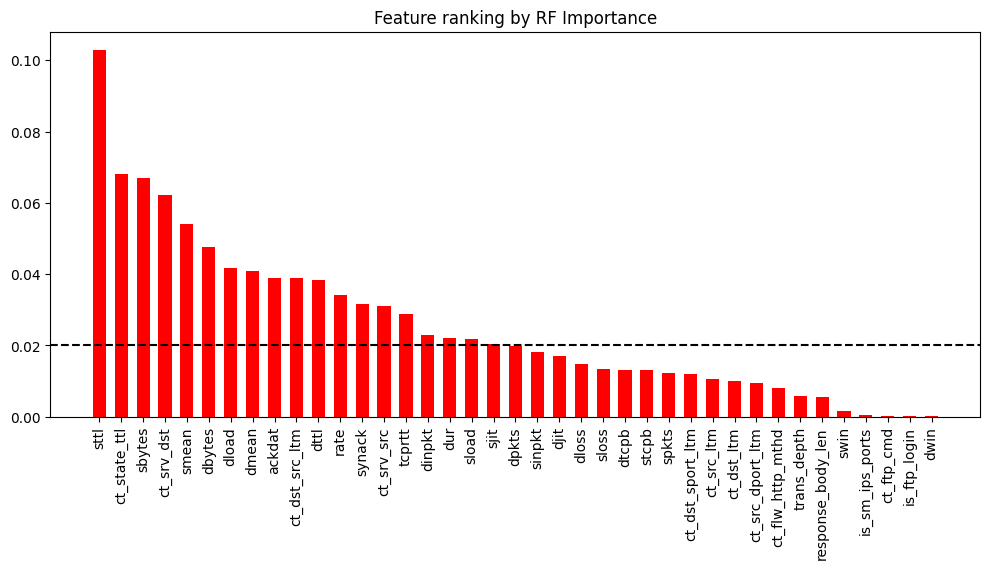

In [21]:
clf = RandomForestClassifier()
clf = clf.fit(X_train_num, y_train_und)
rf_info = pd.Series(clf.feature_importances_)
rf_info.index = X_train_num.columns
rf_info = rf_info.sort_values(ascending = False)
plt.figure(figsize=(12,5))
plt.title("Feature ranking by RF Importance")
plt.bar(rf_info.index, rf_info, width=0.6, color="red")
plt.axhline(0.02, c="black", ls="--")
plt.xticks(rotation=90)
plt.show()

In [41]:
mutual_info = mutual_info[mutual_info>0.25]
rf_info = rf_info[rf_info>0.02]
igrf_intersection = set(rf_info.index).intersection(set(mutual_info.index))
igrf_union = set(rf_info.index).union(set(mutual_info.index))
print("IG: ", len(mutual_info))
print("RF: ", len(rf_info))
print("IGRF Intersection: ", len(igrf_intersection))
print("IGRF Union: ", len(igrf_union))

IG:  18
RF:  19
IGRF Intersection:  16
IGRF Union:  21


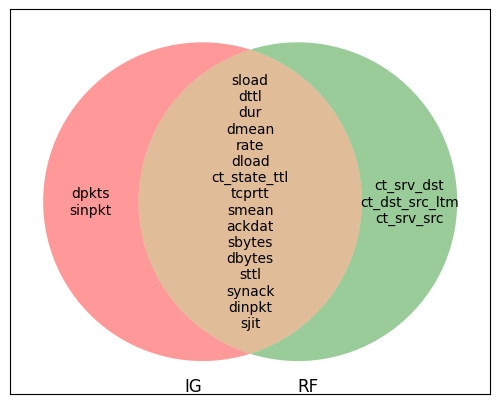

In [40]:
plt.figure(figsize=(12,5))
venn = venn2(subsets = (3, 3, 5), set_labels=('IG', 'RF'))
venn.get_label_by_id('100').set_text(',\n'.join(set(mutual_info.index)-set(rf_info.index)))
venn.get_label_by_id('110').set_text(',\n'.join(set(mutual_info.index)&set(rf_info.index)))
venn.get_label_by_id('010').set_text(',\n'.join(set(rf_info.index)-set(mutual_info.index)))
plt.axis('on')
plt.show()

In [24]:
# df_train.to_csv('../UNSW-NB15/data/UNSW_NB15_training-set_cleaned.csv', float_format='%f', index=False)
# df_test.to_csv('../UNSW-NB15/data/UNSW_NB15_testing-set_cleaned.csv', float_format='%f', index=False)